In [2]:
# Evaluation mean f1-score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/train_data.npy')
# classes 0 - 3
y = np.genfromtxt('data/train_labels.csv', delimiter=' ', dtype=np.float32)

unique, counts = np.unique(y, return_counts=True)
print(counts) # features: 18286

[4040 1965  227  590]


In [169]:
from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=384, n_jobs=-1)

ind_train = np.concatenate((np.where(y == 0)[0][0:3000], np.where(y == 1)[0][:1500], np.where(y == 2)[0][:180], np.where(y == 3)[0][:450]))
ind_test = list(set(range(0, len(X))) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

#X_train, y_train = sm.fit_sample(X_train, y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(counts) # features: 18286

def sampleIt(X, y):
    X_new = []; y_new = []; sample_w = []
    for i, row_y in enumerate(y):
        for cl, p_i in enumerate(row_y):
            X_new.append(X[i])
            y_new.append(cl)
            sample_w.append(p_i)
    return X_new, y_new, sample_w

# X_train, y_train, w_train = sampleIt(X_train, y_train)
# X_test, y_test, w_test = sampleIt(X_test, y_test)

[3000 1500  180  450]


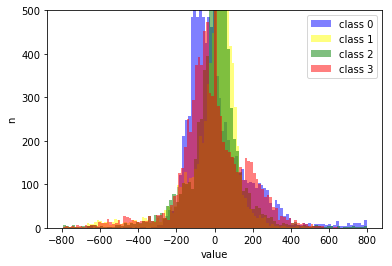

In [88]:
min_v = -800; max_v = 800;
plt.hist(X[0][(X[0] > min_v) & (X[0] < max_v) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[3][(X[3] > min_v) & (X[3] < max_v) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[45][(X[45] > min_v) & (X[45] < max_v) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[500][(X[500] > min_v) & (X[500] < max_v) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.ylim([0, 500])
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=100, hist_bins=None):
        self.splits = splits
        self.hist_bins = hist_bins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967])]
            
        for row in X:
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])
                #features.append(np.histogram(split, bins=self.hist_bins)[0])

            X_new.append(np.array(features).flatten())

        #print("features: "+str(len(X_new[0])))
        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=80)),
    ('scaler', StandardScaler()),
#    ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=-1))
    ('logreg', GradientBoostingClassifier(n_estimators=30))
#      ('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [184]:
from sklearn.metrics import f1_score, log_loss

# pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train}); print('fitted')
pipe.fit(X_train, y_train); print('fitted')
y_pred = pipe.predict(X_test);
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); print(len(y_test[y_test==0]) / len(y_test))

# Pass score: 0.62837
# Splits 80: 0.5739644970414202 (first class 2000 rows)
# GradientBoostingClassifier, 100, 0.6505588428665352
# 30, 0.6794871794871795 / 0.7176820208023774 [2200  463   26    3]
# Smote 4x2000: 0.5197409006785935
# 3k: 0.644

fitted
f1 score: 0.6306146572104019
[1534  143   13    2]
0.6146572104018913


In [199]:
import random
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=80, hist_bins=a)),
        ('scaler', StandardScaler()),
 #       ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=2))
        ('logreg', GradientBoostingClassifier(n_estimators=30))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test);

    score = f1_score(y_test, y_pred, average='micro')
    print("\x1b[1;31m%s\x1b[0m \t%s" % (score, a))
    
#for i in [0.01, 0.1, 1, 10]:
#    run(i)
hist_bins = [np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967]),
            np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967])]
#hist_bins = [[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = []
        for b2 in b1:
            bins_new2.append(random.uniform(b2 - 80, b2 + 80))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.633569739953 	[array([-1112.87176022,  -438.49611427,  -433.48919098,  -370.30332187,
        -165.39410994,   -86.0370457 ,   118.59400833,   167.98778404,
         281.63359266,   808.82585263,  1070.35466242]), array([-1022.01211256,  -564.4344722 ,  -389.98835942,  -331.41011592,
        -109.51878911,   -23.82462512,   -16.80718208,   323.626553  ,
         432.09990781,   776.77812037,  1072.0451469 ]), array([-1093.72197546,  -422.3457775 ,  -263.5435532 ,  -242.15449303,
        -217.29304383,   -70.59620788,    57.12614942,   242.76778461,
         290.53844879,   803.43430155,  1091.85581938]), array([-1067.87495645,  -590.67011384,  -437.10050869,  -313.16663552,
        -214.91736282,   -67.45184606,    46.31389225,   158.31036142,
         280.70715318,   510.15084472,   979.6734256 ]), array([ -957.72153213,  -573.88911353,  -445.80017451,  -377.10389849,
        -200.32736575,  -177.72964996,   109.40165475,   261.07706793,
         299.88144912,   655.3208004 ,  1073.

KeyboardInterrupt: 

In [67]:
# Get clusters as a start for the bins
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, n_jobs=-1, random_state=99)#, init="k-means++")

ind = np.concatenate((np.where(y == 0)[0][0:3], np.where(y == 1)[0][:3], np.where(y == 2)[0][:3], np.where(y == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    sample = sample[(sample > -500) & (sample < 500)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

#edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
#edges.append(1700)
"""

"""
edges

Process ForkPoolWorker-131:
Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/pyt

KeyboardInterrupt: 

In [198]:
class KnnDtw(BaseEstimator, TransformerMixin):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = np.inf * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    print(dm_count)
                    
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    dm_count += 1
                    print(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()
    
model = KnnDtw()
model.fit(X_train, y_train); print('fitted')
y_pred = model.predict(X_test)[0]
print(y_pred)
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); print(len(y_test[y_test==0]) / len(y_test))

fitted


KeyboardInterrupt: 

In [203]:
from sklearn.metrics import classification_report
import matplotlib.pylab as plt
import numpy as np

class ts_classifier(object):
	
	def __init__(self,plotter=False):
		'''
		preds is a list of predictions that will be made.
		plotter indicates whether to plot each nearest neighbor as it is found.
		'''
		self.preds=[]
		self.plotter=plotter
	
	def predict(self,train,test,w,progress=False):
		'''
		1-nearest neighbor classification algorithm using LB_Keogh lower 
		bound as similarity measure. Option to use DTW distance instead
		but is much slower.
		'''
		for ind,i in enumerate(test):
			if progress:
				print(str(ind+1)+' points classified')
			min_dist=float('inf')
			closest_seq=[]
	
			for j in train:
				if self.LB_Keogh(i,j[:-1],5)<min_dist:
					dist=self.DTWDistance(i,j[:-1],w)
					if dist<min_dist:
						min_dist=dist
						closest_seq=j
			self.preds.append(closest_seq[-1])
			
			if self.plotter: 
				plt.plot(i)
				plt.plot(closest_seq[:-1])
				plt.legend(['Test Series','Nearest Neighbor in Training Set'])
				plt.title('Nearest Neighbor in Training Set - Prediction ='+str(closest_seq[-1]))
				plt.show()
	    
	    
	def performance(self,true_results):
		'''
		If the actual test set labels are known, can determine classification
		accuracy.
		'''
		return classification_report(true_results,self.preds)
	
	def get_preds(self):
		return self.preds
	
	
	def DTWDistance(self,s1,s2,w=None):
		'''
		Calculates dynamic time warping Euclidean distance between two
		sequences. Option to enforce locality constraint for window w.
		'''
		DTW={}
    
		if w:
			w = max(w, abs(len(s1)-len(s2)))
    
			for i in range(-1,len(s1)):
				for j in range(-1,len(s2)):
					DTW[(i, j)] = float('inf')
			
		else:
		    for i in range(len(s1)):
		        DTW[(i, -1)] = float('inf')
		    for i in range(len(s2)):
		        DTW[(-1, i)] = float('inf')
		
		DTW[(-1, -1)] = 0
	
		for i in range(len(s1)):
			if w:
				for j in range(max(0, i-w), min(len(s2), i+w)):
					dist= (s1[i]-s2[j])**2
					DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
			else:
				for j in range(len(s2)):
					dist= (s1[i]-s2[j])**2
					DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
			
		return np.sqrt(DTW[len(s1)-1, len(s2)-1])
	   
	def LB_Keogh(self,s1,s2,r):
		'''
		Calculates LB_Keough lower bound to dynamic time warping. Linear
		complexity compared to quadratic complexity of dtw.
		'''
		LB_sum=0
		for ind,i in enumerate(s1):
	        
			lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
			upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
	        
			if i>upper_bound:
				LB_sum=LB_sum+(i-upper_bound)**2
			elif i<lower_bound:
				LB_sum=LB_sum+(i-lower_bound)**2
	    
		return np.sqrt(LB_sum)
    
train = np.concatenate((X_train, [[i] for i in y_train]), axis=1)
test = np.concatenate((X_test, [[i] for i in y_test]), axis=1)
model = ts_classifier()
model.predict(train, test, 3, progress=True)

1 points classified


KeyboardInterrupt: 